# Setup

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import tensorflow as tf
from numpy.typing import NDArray

RANDOM_SEED = 42

sys.path.append(os.path.abspath("."))
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

2025-08-17 15:53:14.936904: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-17 15:53:14.936969: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-17 15:53:14.938005: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-17 15:53:15.019975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
gpus = tf.config.list_physical_devices('GPU')
assert len(gpus) >= 1 # should have a GPU!
gpus

2025-08-17 15:53:18.300294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 15:53:18.318258: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 15:53:18.318289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [4]:
NUM_VALID = 5000

# Type declarations to make working with it easier/get type hints
X_test: NDArray[np.uint8]
y_test: NDArray[np.uint8]

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train_full = X_train_full / 255.

X_test = X_test / 255.

# all items besides the last 5000 ones part of the core train set
X_train: NDArray[np.uint8] = X_train_full[:-NUM_VALID]
y_train: NDArray[np.uint8] = y_train_full[:-NUM_VALID]

# the last 5000 items are for validation
X_valid: NDArray[np.uint8] = X_train_full[-NUM_VALID:]
y_valid: NDArray[np.uint8] = y_train_full[-NUM_VALID:]

In [5]:
X_train.shape # the actual pixel values for the digits. 28x28 images

(55000, 28, 28)

In [6]:
X_train

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [7]:
def draw_img(X: NDArray[np.uint8], y: NDArray[np.uint8], index: int):
    plt.imshow(X[index], cmap="binary")
    plt.text(
        0.05, 0.05, f"Label: {y[index]}",
        fontsize=12,
        color="white",
        bbox=dict(facecolor="black", alpha=0.7, boxstyle="round,pad=0.3")
    )
    plt.axis('off')
    plt.show()

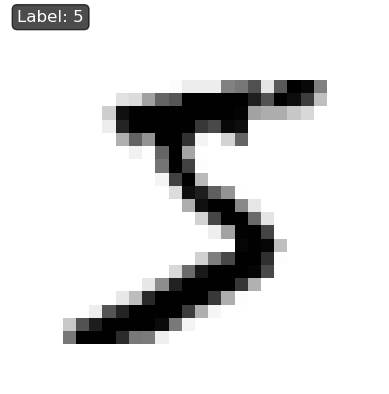

In [8]:
draw_img(X_train, y_train, 0)

In [80]:
from IPython.display import HTML, display
import base64
from io import BytesIO
import matplotlib.pyplot as plt

def image_to_base64(img):
    buf = BytesIO()
    plt.imsave(buf, img, cmap="binary")
    buf.seek(0)
    return base64.b64encode(buf.read()).decode('utf-8')

def render_image_grid(X, y, per_row: int = 10, size: int = 64):
    html = ['<table><tr>']
    for i, img in enumerate(X):
        if i % per_row == 0 and i != 0:
            html.append('</tr><tr>')
        b64 = image_to_base64(img)
        label = y[i]
        html.append(f"""
                    <td style='text-align:center; padding:5px'>
                        <img src='data:image/png;base64,{b64}' width='64' height='64'>
                        <br>
                        <p>label: <b>{label}</b></p>
                    </td>""")

    html.append(f'</tr></table><p>Total: {len(X)}</p>')
    html_final = ''.join(html)
    display(HTML(html_final))

In [25]:
HOW_MANY_TO_RENDER = 40
PER_ROW = 10
render_image_grid(X_train[:HOW_MANY_TO_RENDER], y_train[:HOW_MANY_TO_RENDER], per_row=PER_ROW)

label: 5,label: 0,label: 4,label: 1,label: 9,label: 2,label: 1,label: 3,label: 1,label: 4
label: 3,label: 5,label: 3,label: 6,label: 1,label: 7,label: 2,label: 8,label: 6,label: 9
label: 4,label: 0,label: 9,label: 1,label: 1,label: 2,label: 4,label: 3,label: 2,label: 7
label: 3,label: 8,label: 6,label: 9,label: 0,label: 5,label: 6,label: 0,label: 7,label: 6


In [26]:
y_train.shape # the classification (which digit is it)

(55000,)

In [27]:
y_train

array([5, 0, 4, ..., 0, 4, 0], dtype=uint8)

# Create Model + Hyperparam Search Setup

In [28]:
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"), # decent default
    tf.keras.layers.Dense(100, activation="relu"), # decent default
    tf.keras.layers.Dense(10, activation="softmax") # softmax output because we have a classification task
])

2025-08-17 16:08:41.448435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 16:08:41.448518: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 16:08:41.448542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 16:08:43.117219: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-17 16:08:43.117268: I tensorflow/compile

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 100)               78500     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 89610 (350.04 KB)
Trainable params: 89610 (350.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


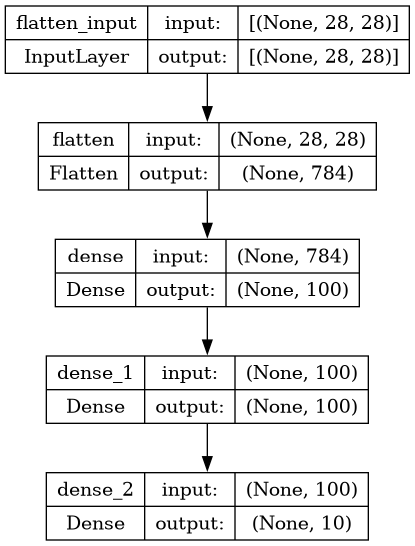

In [30]:
tf.keras.utils.plot_model(model, "10_mlp_model.png", show_shapes=True)

!!!!
Following along with the official solution for this exponential learning rate part as I didn't know how to do it and didn't want to mess around in some unclear direction.

In [89]:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor: float):
        self.factor = factor
        self.rates: list[np.float32] = []
        self.losses: list[np.float32] = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr

        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [93]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [94]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [95]:
# so this starts us off with a small learning rate of 10**(-3) and makes it grow by 0.5% at each iteration

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(
    loss="sparse_categorical_crossentropy",  # same as in my setup
    optimizer=optimizer,
    metrics=["accuracy"]
)
expon_lr = ExponentialLearningRate(factor=1.005) # <- this is the 0.5% increase

Training it for one epoch

In [96]:
history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_data=(X_valid, y_valid),
    callbacks=[expon_lr]
)

1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.5717 - val_loss: nan - val_accuracy: 0.0978


Plotting the loss as a function of the learning rate:

Text(0, 0.5, 'Loss')

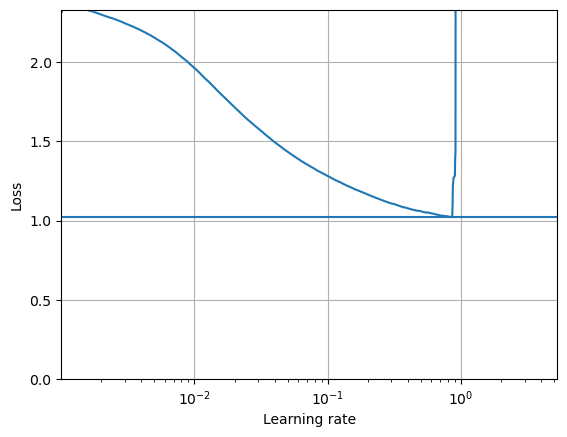

In [97]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

So the loss starts going up when the learning rate goes over `6e-1` (I did not get the same exact result as Geron but it's about the same ish result for me). As suggested let's go with half of that @ `3e-1`.
(Follows the suggestion on p.351 in the book as well)

In [106]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Copying all of this as is to compare the setup to what I ended up doing below...

In [107]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [108]:
optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1) # <- here's that suggested learning rate that we found above.
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [109]:
from pathlib import Path

run_index = 2 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_002')

In [111]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

# checkpoints! which I forgot to add in my solution, but of course I see where they would make sense even in my setup.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_mnist_model.keras", # (<- model will be saved to our current dir. Apparently it's some sort of protobuf format. We can actually store and load these anywhere else due to this including TensorFlow.js which uses WebGL shaders to run inference)
    monitor='val_accuracy',
    mode='max',
    # save_best_only=True (doesn't work for some reason, possibly this one https://github.com/keras-team/tf-keras/issues/151)
)

history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb] # <- similar setup except now we're also saving checkpoints!
)

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0930 - accuracy: 0.9713 - val_loss: 0.0858 - val_accuracy: 0.9740
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0702 - accuracy: 0.9777 - val_loss: 0.0925 - val_accuracy: 0.9736
Epoch 3/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0514 - accuracy: 0.9832 - val_loss: 0.0734 - val_accuracy: 0.9822
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0389 - accuracy: 0.9871 - val_loss: 0.0797 - val_accuracy: 0.9788
Epoch 5/100
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0296 - accuracy: 0.9906 - val_loss: 0.0788 - val_accuracy: 0.9818
Epoch 6/100
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0238 - accuracy: 0.9916 - val_loss: 0.1057 - val_accuracy: 0.9762
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0196 - accuracy: 0.9938 - val_loss: 0.0783 - val_ac

In [112]:
model = tf.keras.models.load_model("my_mnist_model.keras") # <- read the (best) model we found above back

model.evaluate(X_test, y_test) # accuracy etc

313/313 [==============================] - 1s 2ms/step - loss: 0.0900 - accuracy: 0.9853


[0.08999065309762955, 0.9853000044822693]

## My Solo Attempt

Which surprisingly got a pretty good accuracy score!

Let's use the hyperparameter tuning approach!

Make a smaller train dataset for the hyperparameter search step, to make it faster. The data is already known to be randomly sorted.

In [31]:
SEARCH_SIZE = 5000

X_train_small = X_train[:SEARCH_SIZE]
y_train_small = y_train[:SEARCH_SIZE]

In [32]:
from time import strftime
from pathlib import Path

# reuse this from the examples since I'm happy with it
def get_run_logdir(root_logdir="my_logs") -> Path:
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir("my_logs_2")
run_logdir

PosixPath('my_logs_2/run_2025_08_17_16_09_08')

In [33]:
import keras_tuner as kt
tf.keras.backend.clear_session()

In [34]:

from keras_tuner import HyperParameters

def build_model(hp: HyperParameters):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=5e-5, max_value=3e-3, sampling="log")
    hidden_activation = hp.Choice("hidden_activation", values=["relu", "tanh"])

    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

    # hidden layers
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=hidden_activation))

    # output layer
    model.add(tf.keras.layers.Dense(10, activation="softmax"))  # softmax because we are multiclass predicting with 10 classes

    model.compile(
        loss="sparse_categorical_crossentropy", # because sparse, categorical values
        optimizer=optimizer,
        metrics=["accuracy"] # optional additional metrics
    )

    return model

In [35]:
# provides updates that we can track in the TensorBoard ui

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    run_logdir
    #profile_batch=(100, 200)  # <- when the profiler updates occur
)

In [36]:
# will stop after not seeing an improvement in the accuracy metric after x backpropagation epochs/steps (gradient descent steps)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=2,
    restore_best_weights=True # reverts the model to the best weights before it is returned
)

In [37]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",  # <- we are optimising for accuracy
    max_trials=25,  # <- run 20 trials
    directory="10_mlp_model",
    project_name="rnd_search_1",
    overwrite=True,  # will overwrite 10_mlp_model/rnd_search_1` dir if it already exists
    seed=RANDOM_SEED
)

random_search_tuner.search(
    X_train_small,
    y_train_small,
    epochs=20,  # <- train every hyperparameter seeded model for 100 epochs (= 100 backpropagation gradient descent steps). We have early stopping so it will not necessarily go all the way
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping_callback, tensorboard_callback]
)

Trial 25 Complete [00h 00m 16s]
val_accuracy: 0.3255999982357025

Best val_accuracy So Far: 0.9531999826431274
Total elapsed time: 00h 07m 10s


In [38]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 23 summary
Hyperparameters:
n_hidden: 5
n_neurons: 180
learning_rate: 0.0002514699093611439
hidden_activation: relu
optimizer: adam
Score: 0.9531999826431274


In [39]:
best_trial.metrics.get_last_value("val_accuracy")

0.9531999826431274

In [40]:
best_model = random_search_tuner.get_best_models(num_models=1)[0]

In [42]:
best_hyperparams = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
best_hyperparams.values

{'n_hidden': 5,
 'n_neurons': 180,
 'learning_rate': 0.0002514699093611439,
 'hidden_activation': 'relu',
 'optimizer': 'adam'}

This is the best model we got so far, which we now train on the full dataset.

In [46]:
# continue/complete training the best model we found above
best_model.fit(
    X_train_full,
    y_train_full,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=20)] # early stop to not keep looping endlessly
)

Epoch 1/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0044 - val_accuracy: 0.9984
Epoch 2/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0056 - accuracy: 0.9982 - val_loss: 0.0033 - val_accuracy: 0.9982
Epoch 3/100
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 4/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0027 - val_accuracy: 0.9996
Epoch 5/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.0028 - val_accuracy: 0.9988
Epoch 6/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.0020 - val_accuracy: 0.9994
Epoch 7/100
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 8.8350e-04 - va

Evaluate the model

In [47]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.1328 - accuracy: 0.9818


In [48]:
test_loss

0.13281020522117615

In [49]:
test_accuracy

0.9818000197410583

Precision and recall

In [ ]:
y_test_pred = best_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


array([[1.9207990e-21, 6.4563804e-18, 1.8135795e-15, ..., 1.0000000e+00,
        2.6278196e-18, 1.3002632e-13],
       [4.6234075e-22, 4.9152288e-23, 1.0000000e+00, ..., 5.0526896e-19,
        1.6511465e-20, 1.4032392e-30],
       [1.2561957e-16, 1.0000000e+00, 8.2470714e-10, ..., 2.2537265e-09,
        2.3640429e-10, 1.3019525e-14],
       ...,
       [4.5243970e-28, 2.3875828e-22, 8.3904715e-25, ..., 4.7979365e-26,
        3.9729107e-27, 4.2998852e-21],
       [5.0204618e-22, 6.7659025e-30, 7.2722001e-29, ..., 1.5340098e-26,
        2.4670886e-21, 1.1356674e-22],
       [1.9782917e-19, 1.7087722e-21, 5.8517464e-20, ..., 1.7125246e-28,
        4.9634770e-18, 1.3124264e-22]], dtype=float32)

In [ ]:
y_test_pred_max = y_test_pred.argmax(axis=1)
y_test_pred_max

array([7, 2, 1, ..., 4, 5, 6])

In [61]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [78]:
from sklearn.metrics import f1_score

f1_score(y_test, y_test_pred_max, average="macro")

0.9817357461841507

In [79]:
from sklearn.metrics import f1_score

f1_score(y_test, y_test_pred_max, average="weighted")

0.9817990641755833

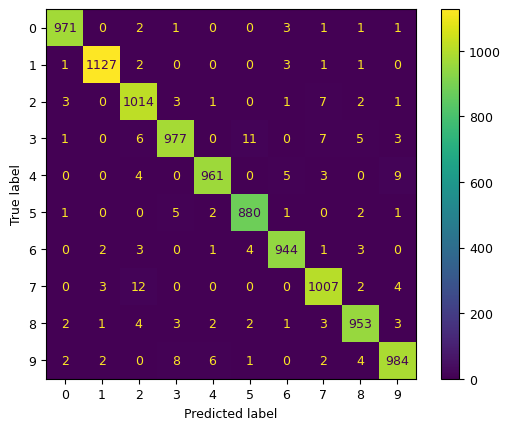

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_max)
plt.show()

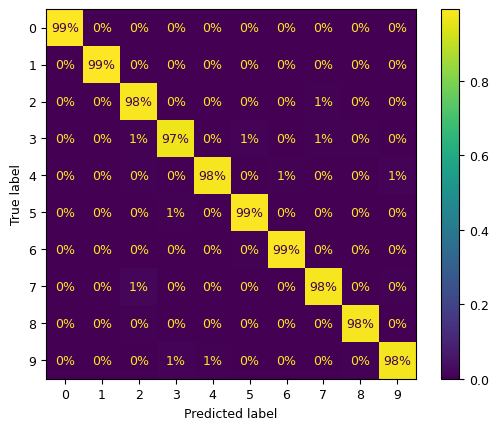

In [66]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred_max,
    normalize="true",
    values_format=".0%"
)

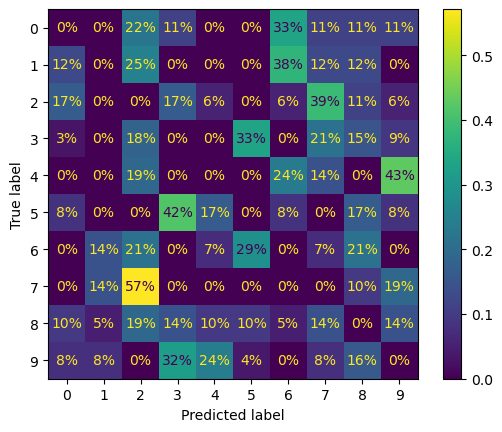

In [68]:
sample_weight = (y_test_pred_max != y_test)
plt.rc('font', size=10)  # extra code
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_test_pred_max,
    sample_weight=sample_weight,
    normalize="true",
    values_format=".0%"
)
plt.show()

Curious which 7s were misidentified?

In [81]:
idxs = (y_test == 7) & (y_test_pred_max != 7)
render_image_grid(X_test[idxs], y_test_pred_max[idxs], PER_ROW)

In [82]:
idxs = (y_test == 5) & (y_test_pred_max != 5)
render_image_grid(X_test[idxs], y_test_pred_max[idxs], PER_ROW)

In [83]:
idxs = (y_test == 4) & (y_test_pred_max != 4)
render_image_grid(X_test[idxs], y_test_pred_max[idxs], PER_ROW)